In [108]:
import os
import random
import warnings
from prophet.plot import add_changepoints_to_plot, plot_seasonality
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import koreanize_matplotlib
# from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm.auto import tqdm
# import logging
# logging.getLogger('Prophet').setLevel(logging.ERROR)

warnings.filterwarnings(action='ignore')

In [109]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(42)  # Seed 고정

In [110]:
info = pd.read_csv('./JH/building_info.csv')
train_df = pd.read_csv('./JH/train.csv')
test_df = pd.read_csv('./JH/test.csv')

In [111]:
train_df

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


## 가장 결과가 좋았던 외생변수 4종을 포함한 코드에 prameter 최적화를 수행한다

In [165]:
test_submission = pd.DataFrame(columns=['num_date_time', 'answer'])
fillzero_train = train_df.fillna(0)
holidays = pd.DataFrame(columns=['holiday', 'ds'])
# holidays["lower_window"] = 1
# holidays["upper_window"] = 1
# valid_len = 168
mape_data = []
def is_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() >= 5:
        return 1
    else:
        return 0
def is_noon(ds):
    date = pd.to_datetime(ds)
    if date.hour >= 7 and date.hour<20:
        return 1
    else:
        return 0
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
for i in tqdm(range(1,101)):
    # 한건물당 168개씩 예측한다
    sample_train = fillzero_train.loc[(fillzero_train["건물번호"] == i), ][:-168]
    sample_test = fillzero_train.loc[(fillzero_train["건물번호"] == i), ][-168:].reset_index(drop=True)
    target = sample_train["num_date_time"].str.split("_").apply(lambda x: x[1])
    test_target = sample_test["num_date_time"].str.split("_").apply(lambda x: x[1])
    sample_train["num_date_time"] = pd.to_datetime(target, format="%Y%m%d %H")
    sample_test["num_date_time"] = pd.to_datetime(test_target, format="%Y%m%d %H")
    data = sample_train.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)": 'y'})[
        ['ds', 'y', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)']].reset_index(drop=True)
    data['weekend'] = data['ds'].apply(is_weekend)
    data['noon'] = data['ds'].apply(is_noon)
    test_data = sample_test.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)": 'y'})[
    ['ds', 'y', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)']].reset_index(drop=True)
    test_data['weekend'] = test_data['ds'].apply(is_weekend)
    test_data['noon'] = test_data['ds'].apply(is_noon)
    sample_x = test_data.drop("y" , axis=1)
    y = test_data["y"]

    m = Prophet(
        # growth: Any = 'linear',
        #      changepoints: Any = None,
        #      n_changepoints: Any = 25,
             changepoint_range = 1,
        #      yearly_seasonality: Any = 'auto',
        #      weekly_seasonality: Any = 'auto',
        #      daily_seasonality = ,
             holidays = holidays,
             # seasonality_mode = 'multiplicative',
             # seasonality_prior_scale = 10,
             holidays_prior_scale =  0.0173,
             changepoint_prior_scale = 0.0142,
        #      mcmc_samples = 30, # 나중에 다시 고려할 것
        #      interval_width =1,
        #      uncertainty_samples = 500,
        #      stan_backend: Any = None
    )
    m.add_seasonality(name='weekend', period=168, fourier_order=1, condition_name='weekend', prior_scale=7)
    m.add_seasonality(name='noon', period=24, fourier_order=1, condition_name='noon', prior_scale=10)

    m.add_country_holidays(country_name='KR')
    m.add_regressor('기온(C)')
    m.add_regressor('강수량(mm)')
    m.add_regressor('풍속(m/s)')
    m.add_regressor('습도(%)')
    m.fit(data
          # ,show_progress = False
          )

    future = m.make_future_dataframe(periods=168, freq='1H')
    future['기온(C)'] = data['기온(C)']
    future['강수량(mm)'] = data['강수량(mm)']
    future['풍속(m/s)'] = data['풍속(m/s)']
    future['습도(%)'] = data['습도(%)']
    future['weekend'] = data['weekend']
    future['noon'] = data['noon']

    future.loc[future.shape[0] - 168:, '기온(C)'] = sample_x['기온(C)'].values
    future.loc[future.shape[0] - 168:, '강수량(mm)'] = sample_x['강수량(mm)'].values
    future.loc[future.shape[0] - 168:, '풍속(m/s)'] = sample_x['풍속(m/s)'].values
    future.loc[future.shape[0] - 168:, '습도(%)'] = sample_x['습도(%)'].values
    future.loc[future.shape[0] - 168:, 'weekend'] = sample_x['weekend'].values
    future.loc[future.shape[0] - 168:, 'noon'] = sample_x['noon'].values

    forecast = m.predict(future)

    answer = forecast[-168:].loc[:, ['ds', 'yhat']].rename(
        columns={"ds": "num_date_time", "yhat": "answer"}).reset_index(drop=True)

    answer["year"] = answer["num_date_time"].dt.year.astype(str)
    answer["month"] = answer["num_date_time"].dt.month.astype(str).str.zfill(2)
    answer["day"] = answer["num_date_time"].dt.day.astype(str).str.zfill(2)
    answer["hour"] = answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
    answer["num_date_time"] = f"{i}_" + answer["year"] + answer["month"] + answer["day"] + ' ' + answer["hour"]
    test_submission = test_submission.append(answer)
    mape_data.append(SMAPE(y,forecast.loc[2040-168:,"yhat"].values))
print(f"SMAPE score is {sum(mape_data)/100}")
# test_submission = test_submission[["num_date_time", "answer"]]
# test_submission.set_index("num_date_time", inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing
15:16:24 - cmdstanpy - INFO - Chain [1] start processing
15:16:24 - cmdstanpy - INFO - Chain [1] done processing
15:16:24 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
15:16:25 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
15:16:26 - cmdstanpy - INFO - Chain [1] start processing
15:16:26 - cmdstanpy - INFO - Chain [1] done processing
15:16:26 - cmdstanpy - INFO - Chain [1] start processing
15:16:26 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing
15:16:27 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing
15:16:27 - cmdstanpy - INFO - Chain [1] done processing
15:16:28 - cmdstanpy - INFO - Chain [1] start processing
15:16:28 - cmdstanpy - INFO - Chain [1]

SMAPE score is 5.7888618453290235


In [166]:
print(f"The Last SMAPE score is {sum(mape_data)/100}")

The Last SMAPE score is 5.7888618453290235


In [153]:
print(f"The Best SMAPE score is {sum(mape_data)/100}")

The Best SMAPE score is 5.7026368309376725


## 평가결과
1. linear 시작 = 6.425072103565819
2. weekend 추가 , fourier_order = 84 = 4.468917925091341
3. noon 추가, fourier_roder = 84 : 4.242046238975441
4. mcmc_sample = 30 : 4.275214333468416 <- 높이면 오르는데 시간이 너무 걸리므로 나중에 60이상으로 밤에 켜놓고 잘 것, 잘나오면 모델 저장도 프로펫 공홈보고 하기(show_progress = False 같이 켜야함)
5. holidays_prior_scale = 0.0173 : 4.064786963965926
6. changepoint_prior_scale = 0.017 : <b>3.690373125224021</b>
7. noon 아침 8시 - 오후 17시 :

In [101]:
future

,ds,기온(C),강수량(mm),풍속(m/s),습도(%),weekend,noon
0,2022-06-01 00:00:00,15.0,0.0,0.3,70.0,0.0,0.0
1,2022-06-01 01:00:00,14.2,0.0,0.1,75.0,0.0,0.0
2,2022-06-01 02:00:00,13.5,0.0,0.1,77.0,0.0,0.0
3,2022-06-01 03:00:00,13.4,0.0,0.2,81.0,0.0,0.0
4,2022-06-01 04:00:00,13.8,0.0,0.2,79.0,0.0,0.0
...,...,...,...,...,...,...,...
2035,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,0.0,1.0
2036,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,0.0,0.0
2037,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,0.0,0.0
2038,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,0.0,0.0


In [102]:
m.train_holiday_names

0                                New Year's Day
1                          Lunar New Year's Day
2     The day preceding of Lunar New Year's Day
3        The second day of Lunar New Year's Day
4                     Independence Movement Day
5                        Birthday of the Buddha
6                                Children's Day
7                                    Labour Day
8                                  Memorial Day
9                                Liberation Day
10                                      Chuseok
11                 The day preceding of Chuseok
12                    The second day of Chuseok
13               Alternative holiday of Chuseok
14                      National Foundation Day
15                                  Hangeul Day
16           Alternative holiday of Hangeul Day
17                                Christmas Day
dtype: object

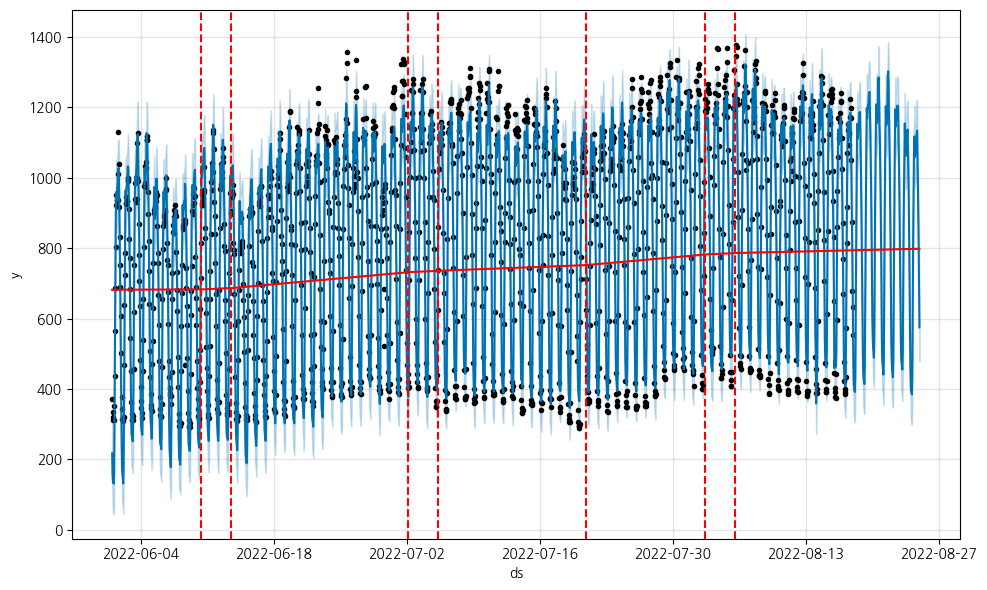

In [103]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

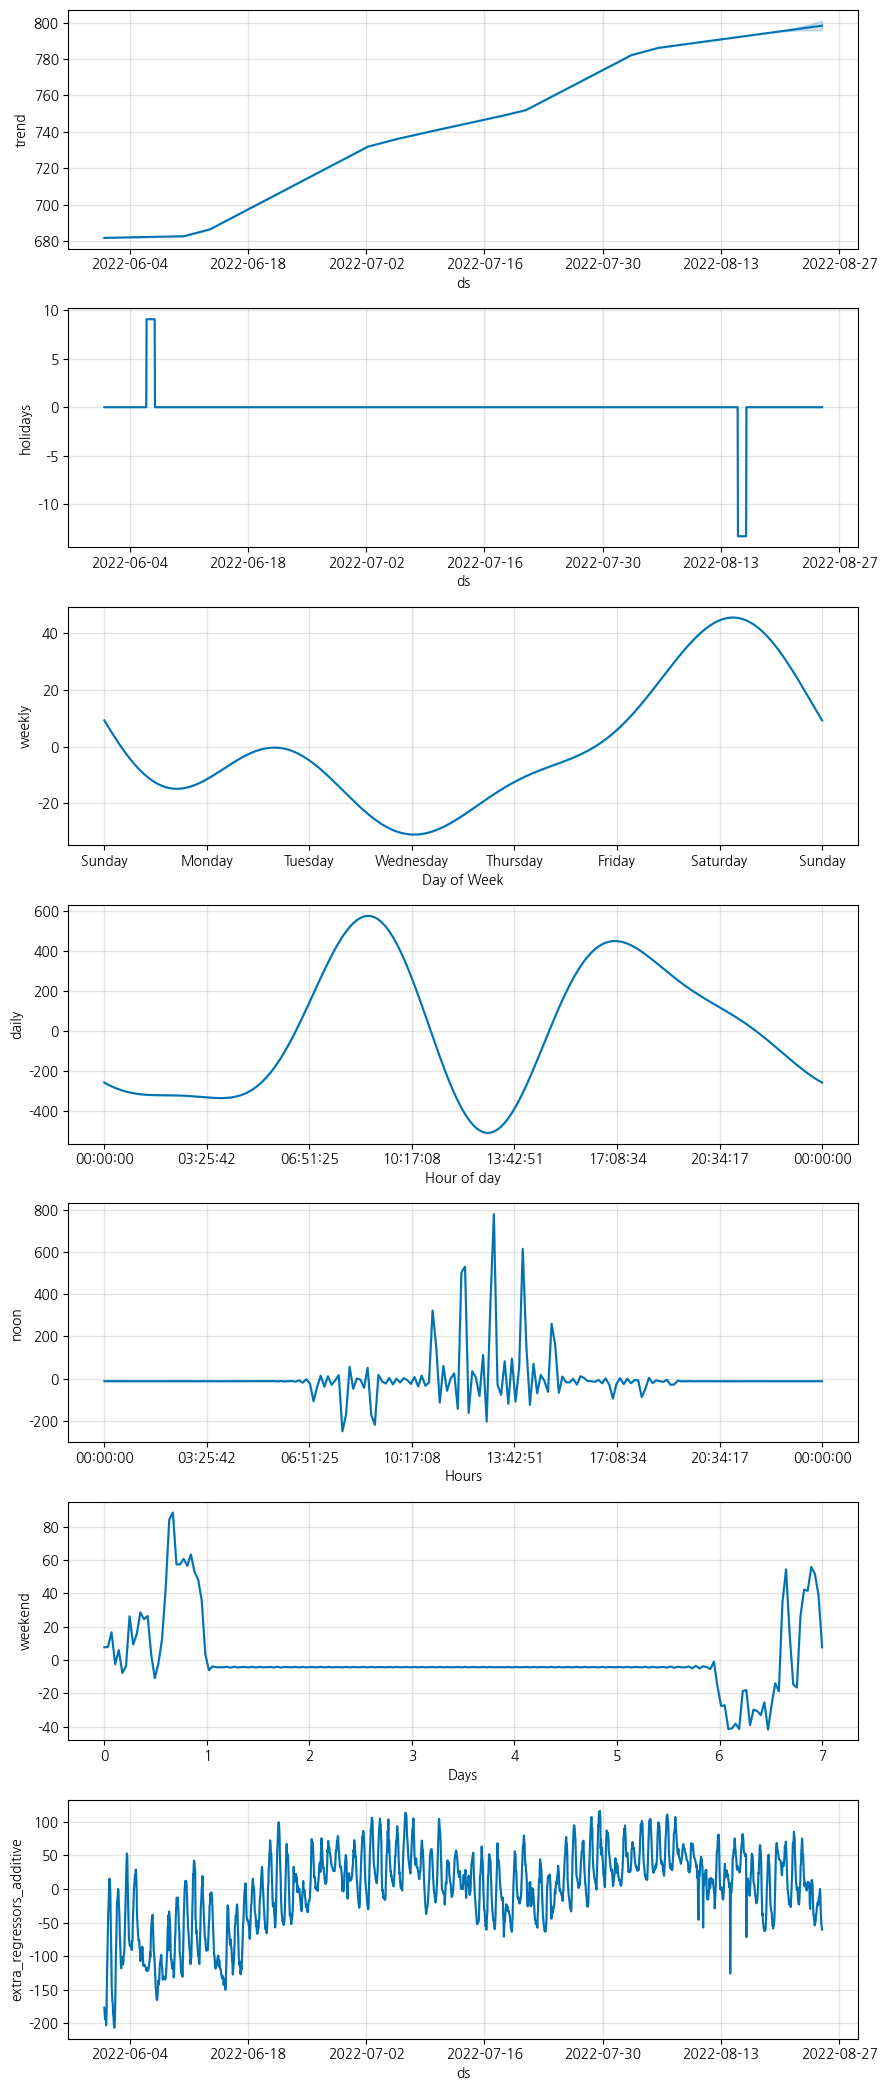

In [104]:
fig = m.plot_components(forecast)